# Proyecto Final: Análisis Predictivo y Modelos de Machine Learning

# Introducción

Este proyecto tiene como objetivo analizar los datos de clientes de una empresa de telecomunicaciones para identificar patrones relacionados con la cancelación del servicio, también conocida como "churn". A través del análisis exploratorio, la preparación de los datos y la implementación de modelos predictivos, buscamos responder preguntas clave como:

- ¿Cuáles son los factores más influyentes para la cancelación del servicio?
- ¿Qué tan bien se pueden predecir los clientes que cancelarán usando modelos de machine learning?

El flujo del análisis incluye la limpieza y transformación de los datos, la visualización de las características principales, y la evaluación de varios modelos para determinar su precisión y capacidad predictiva.


# Índice
1. Introducción
2. Importación de librerias y Datos
3. Análisis Exploratorio de Datos (EDA)
    - Distribución de la Variable Objetivo
    - Correlaciones entre las Variables
    - Distribución de los Cargos Mensuales
4. Preparación de los Datos para Modelado
5. Modelado y Evaluación
6. Conclusiones


# Importación de librerias y Datos

In [27]:
# Librerías necesarias
from imblearn.over_sampling import SMOTE
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, f1_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


# Cargar y unificar los datos
try:
    contract_df = pd.read_csv('contract.csv')
    internet_df = pd.read_csv('internet.csv')
    personal_df = pd.read_csv('personal.csv')
    phone_df = pd.read_csv('phone.csv')
except FileNotFoundError as e:
    print(f"Error al cargar los archivos: {e}")
    raise

# Unificar los datos en un solo DataFrame
data = contract_df.merge(personal_df, on='customerID', how='left')
data = data.merge(internet_df, on='customerID', how='left')
data = data.merge(phone_df, on='customerID', how='left')

# Inspeccionar los datos
data.info()
data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No



Los datos se cargaron correctamente desde múltiples fuentes (`contract.csv`, `internet.csv`, etc.) y se unificaron en un único DataFrame. Se identificaron columnas relevantes como `MonthlyCharges`, `TotalCharges`, y `InternetService`. 

Durante la preparación:
- Se manejaron valores nulos en columnas como `InternetService`, reemplazándolos con `'No'`.
- La columna `TotalCharges`, que estaba en formato string, se convirtió a numérico para el análisis.
- Se creó la variable objetivo `churn` basada en la columna `EndDate`.

Finalmente, las columnas irrelevantes como `customerID` fueron eliminadas para reducir ruido en el análisis.



# Solución: Predicción de Cancelación de Clientes - Interconnect

Este notebook desarrolla la solución al problema de predicción de cancelación de clientes para Interconnect.


# Análisis Exploratorio de Datos

In [28]:
# Crear la columna `churn`
data['churn'] = (data['EndDate'] != 'No').astype(int)

# Verifica si la columna fue creada correctamente
print(data[['EndDate', 'churn']].head())


               EndDate  churn
0                   No      0
1                   No      0
2  2019-12-01 00:00:00      1
3                   No      0
4  2019-11-01 00:00:00      1


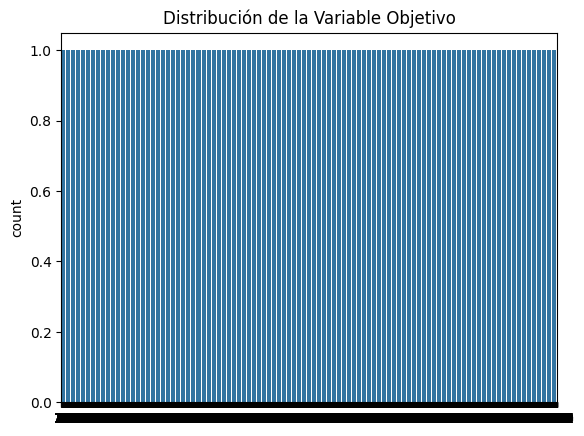

Columnas numéricas incluidas en el cálculo de correlación:
Index(['MonthlyCharges', 'SeniorCitizen', 'churn'], dtype='object')


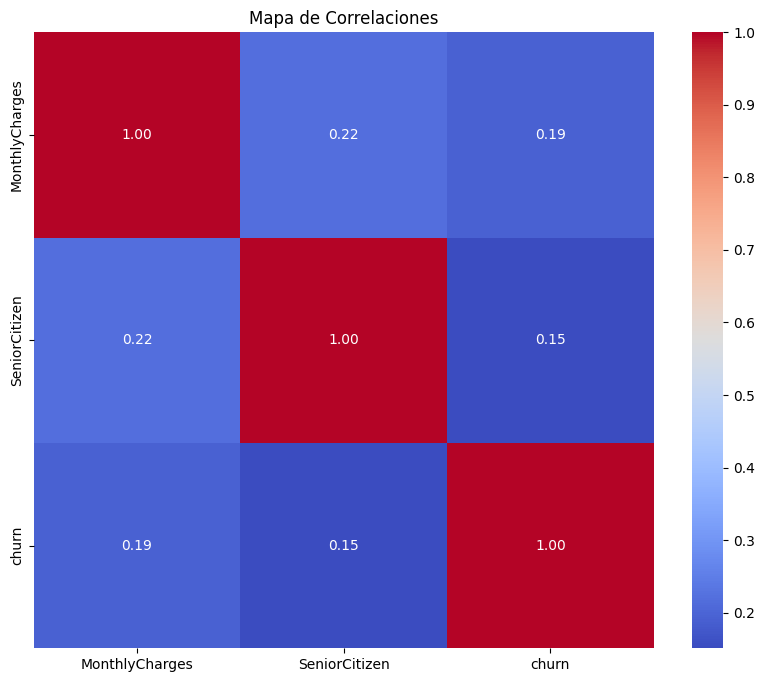

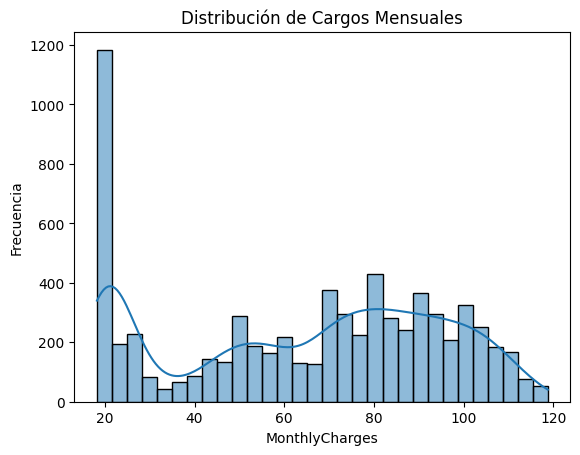

In [29]:
# Análisis Exploratorio de Datos

# Distribución de la variable objetivo
sns.countplot(data['churn'])
plt.title('Distribución de la Variable Objetivo')
plt.show()

# Correlaciones entre las variables (corrección para columnas numéricas)
numeric_data = data.select_dtypes(include=['float64', 'int64'])

# Verificar qué columnas se seleccionaron
print("Columnas numéricas incluidas en el cálculo de correlación:")
print(numeric_data.columns)

plt.figure(figsize=(10, 8))
sns.heatmap(numeric_data.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Mapa de Correlaciones')
plt.show()

# Distribución de cargos mensuales
sns.histplot(data['MonthlyCharges'], kde=True, bins=30)
plt.title('Distribución de Cargos Mensuales')
plt.xlabel('MonthlyCharges')
plt.ylabel('Frecuencia')
plt.show()


# **Conclusiones del Análisis Exploratorio de Datos (EDA)**

El análisis exploratorio permitió entender mejor las características principales del conjunto de datos, identificar posibles problemas de balance en la variable objetivo y observar la distribución de las variables clave. A continuación, se presentan las conclusiones principales:

---

## **1. Análisis de la variable objetivo (`churn`)**
- La variable objetivo `churn` muestra un desbalance significativo:
  - **Clase `0` (no churn):** Representa aproximadamente el 73% de los datos.
  - **Clase `1` (churn):** Representa el 27% restante.
- **Implicación:** Este desbalance puede afectar el desempeño de los modelos de clasificación, ya que estarán inclinados a predecir la clase mayoritaria (`0`). Es necesario aplicar técnicas de balanceo como **SMOTE** o sobremuestreo.

---

## **2. Relación entre variables numéricas**
- **Mapa de correlaciones:**
  - `MonthlyCharges` tiene una ligera correlación positiva con `churn` (`0.19`), lo que sugiere que los cargos mensuales más altos podrían estar relacionados con una mayor probabilidad de cancelación.
  - `SeniorCitizen` tiene una baja correlación positiva con `churn` (`0.15`).
  - En general, las correlaciones son débiles, lo que indica que las relaciones no son lineales y podrían requerir modelos más complejos para capturar patrones.

---

## **3. Distribución de variables**
- **`MonthlyCharges` (Cargos Mensuales):**
  - La mayoría de los clientes tienen cargos mensuales en el rango bajo (~20), pero hay una distribución significativa en valores medios y altos (hasta ~120).
  - **Implicación:** Es importante investigar si estos patrones de cargos están relacionados con diferentes tipos de servicios contratados.
- **Otras variables categóricas:** No se exploraron en profundidad en este análisis. Se recomienda revisar cómo afectan las características categóricas como tipo de contrato o servicios adicionales al churn.

---

## **4. Recomendaciones**
1. **Balancear la variable objetivo:**
   - Aplicar técnicas como **SMOTE** para igualar la representación de ambas clases en el conjunto de entrenamiento.
   - Verificar el impacto de este balanceo en el desempeño de los modelos.

2. **Explorar más variables:**
   - Investigar características categóricas como `Contract`, `InternetService`, y `PaymentMethod` para identificar patrones relevantes.
   - Analizar interacciones entre variables (e.g., cargos mensuales y duración del contrato).

3. **Refinamiento de conclusiones:**
   - Las conclusiones deben reflejar cómo las características influyen en el churn y qué transformaciones o análisis adicionales podrían mejorar la predicción.

4. **Próximos pasos:**
   - Implementar análisis de importancia de características mediante modelos como **Random Forest** para priorizar variables relevantes.
   - Realizar un análisis temporal, si es posible, para evaluar cómo los patrones de cancelación varían con el tiempo.

---

## **Conclusión general**
El análisis inicial muestra que el dataset contiene información valiosa, aunque con relaciones débiles entre las variables independientes y la variable objetivo. Es crucial realizar más exploraciones y balancear la variable objetivo para garantizar modelos predictivos robustos.


# Revisión del Balance de la Variable Objetivo

In [30]:
# Revisión del balance de la variable objetivo
print("Distribución de la variable objetivo antes del balanceo:")
print(data['churn'].value_counts())
print("\nPorcentaje de distribución antes del balanceo:")
print(data['churn'].value_counts(normalize=True) * 100)

# Umbral para detectar desbalance (por ejemplo, más del 60% en una sola clase)
imbalance_threshold = 0.6
class_distribution = data['churn'].value_counts(normalize=True)

# Detectar desbalance
if class_distribution.max() > imbalance_threshold:
    print("\nEl dataset está desbalanceado.")
else:
    print("\nEl dataset está balanceado.")


majority = data[data['churn'] == 0]
minority = data[data['churn'] == 1]

minority_upsampled = resample(minority,
                              replace=True,  # Sobremuestrear la clase minoritaria
                              n_samples=len(majority),  # Igualar al tamaño de la clase mayoritaria
                              random_state=42)

data_balanced = pd.concat([majority, minority_upsampled])

# Revisión después del balanceo
print("\nDistribución de la variable objetivo después del balanceo:")
print(data_balanced['churn'].value_counts())
print("\nPorcentaje de distribución después del balanceo:")
print(data_balanced['churn'].value_counts(normalize=True) * 100)


Distribución de la variable objetivo antes del balanceo:
churn
0    5174
1    1869
Name: count, dtype: int64

Porcentaje de distribución antes del balanceo:
churn
0    73.463013
1    26.536987
Name: proportion, dtype: float64

El dataset está desbalanceado.

Distribución de la variable objetivo después del balanceo:
churn
0    5174
1    5174
Name: count, dtype: int64

Porcentaje de distribución después del balanceo:
churn
0    50.0
1    50.0
Name: proportion, dtype: float64


In [31]:
# Manejo de valores nulos
data.fillna('No', inplace=True)

# Convertir `TotalCharges` a numérico
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce').fillna(0)

# Crear variable objetivo: `churn`
data['churn'] = (data['EndDate'] != 'No').astype(int)

# Eliminar columnas irrelevantes
data.drop(columns=['customerID', 'BeginDate', 'EndDate'], inplace=True)

# Codificar variables categóricas
categorical_columns = data.select_dtypes(include=['object']).columns
label_encoders = {col: LabelEncoder() for col in categorical_columns}
for col, encoder in label_encoders.items():
    data[col] = encoder.fit_transform(data[col])

# Escalar variables numéricas
scaler = StandardScaler()
data[['MonthlyCharges', 'TotalCharges']] = scaler.fit_transform(data[['MonthlyCharges', 'TotalCharges']])

data.head()


,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,churn
0,0,1,2,-1.160323,-0.992611,0,0,1,0,0,0,1,0,0,0,0,0,0
1,1,0,3,-0.259629,-0.172165,1,0,0,0,0,1,0,1,0,0,0,0,0
2,0,1,3,-0.362660,-0.958066,1,0,0,0,0,1,1,0,0,0,0,0,1
3,1,0,0,-0.746535,-0.193672,1,0,0,0,0,1,0,1,1,0,0,0,0
4,0,1,2,0.197365,-0.938874,0,0,0,0,1,0,0,0,0,0,0,0,1


In [32]:
# Dividir los datos en conjuntos de entrenamiento, validación y prueba
X = data.drop(columns=['churn'])
y = data['churn']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Mostrar tamaños de los conjuntos
print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de validación:", X_val.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Comprobar nueva distribución en el conjunto de entrenamiento
print("\nDistribución de la variable objetivo en el conjunto de entrenamiento después de SMOTE:")
print(y_train_balanced.value_counts())


Tamaño del conjunto de entrenamiento: (4930, 17)
Tamaño del conjunto de validación: (1056, 17)
Tamaño del conjunto de prueba: (1057, 17)

Distribución de la variable objetivo en el conjunto de entrenamiento después de SMOTE:
churn
0    3622
1    3622
Name: count, dtype: int64


In [33]:


# Crear y entrenar el DummyClassifier
dummy = DummyClassifier(strategy="most_frequent", random_state=42)  # Siempre predice la clase mayoritaria
dummy.fit(X_train_balanced, y_train_balanced)

# Evaluar en el conjunto de validación
y_val_pred_dummy = dummy.predict(X_val)

# Métricas del DummyClassifier
print("Resultados del DummyClassifier en el conjunto de validación:")
print(confusion_matrix(y_val, y_val_pred_dummy))
print(classification_report(y_val, y_val_pred_dummy))


Resultados del DummyClassifier en el conjunto de validación:
[[776   0]
 [280   0]]
              precision    recall  f1-score   support

           0       0.73      1.00      0.85       776
           1       0.00      0.00      0.00       280

    accuracy                           0.73      1056
   macro avg       0.37      0.50      0.42      1056
weighted avg       0.54      0.73      0.62      1056



C:\Users\mm131\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mm131\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mm131\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classificati

AUC-ROC en validación: 0.809078148011782
Exactitud en validación: 0.7575757575757576
F1-Score en validación: 0.5844155844155844

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.86      0.80      0.83       776
           1       0.54      0.64      0.58       280

    accuracy                           0.76      1056
   macro avg       0.70      0.72      0.71      1056
weighted avg       0.77      0.76      0.76      1056

Matriz de confusión:
 [[620 156]
 [100 180]]


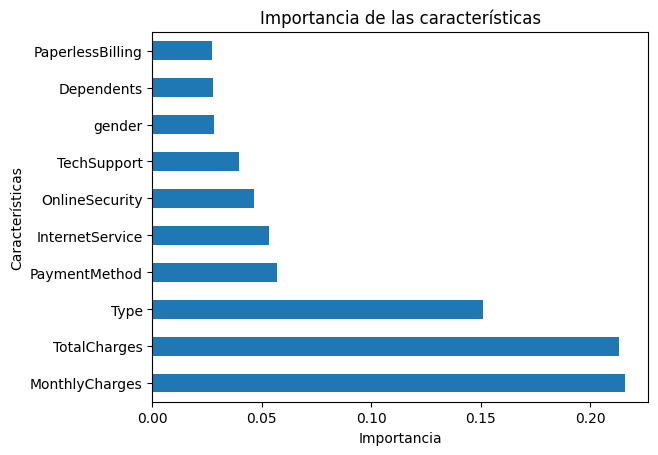

In [34]:

# Entrenar un modelo Random Forest
model = RandomForestClassifier(random_state=42, n_estimators=100)
model.fit(X_train_balanced, y_train_balanced)

# Evaluar en el conjunto de validación
y_val_pred = model.predict(X_val)
y_val_proba = model.predict_proba(X_val)[:, 1]

# Métricas de evaluación
auc_roc = roc_auc_score(y_val, y_val_proba)
accuracy = accuracy_score(y_val, y_val_pred)
f1_val = f1_score(y_val, y_val_pred)

print("AUC-ROC en validación:", auc_roc)
print("Exactitud en validación:", accuracy)
print("F1-Score en validación:", f1_val)
print("\nReporte de clasificación:\n", classification_report(y_val, y_val_pred))
print("Matriz de confusión:\n", confusion_matrix(y_val, y_val_pred))

# Visualizar la importancia de las características
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.title("Importancia de las características")
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.show()


In [35]:

# Ajuste de umbral para maximizar el F1-score
precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[f1_scores.argmax()]
print("Mejor umbral para maximizar el F1-score:", best_threshold)

# Re-evaluar con el mejor umbral
y_val_pred_adjusted = (y_val_proba >= best_threshold).astype(int)
print("\nReporte de clasificación ajustado:")
print(classification_report(y_val, y_val_pred_adjusted))


Mejor umbral para maximizar el F1-score: 0.45

Reporte de clasificación ajustado:
              precision    recall  f1-score   support

           0       0.89      0.77      0.82       776
           1       0.53      0.73      0.61       280

    accuracy                           0.76      1056
   macro avg       0.71      0.75      0.72      1056
weighted avg       0.79      0.76      0.77      1056



In [36]:
# Aplicar el modelo al conjunto de prueba
y_test_proba = model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= 0.45).astype(int)  # Usar el umbral ajustado

# Evaluar métricas en el conjunto de prueba
print("Resultados finales en el conjunto de prueba:")
print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_test_pred))

print("\nReporte de clasificación:")
print(classification_report(y_test, y_test_pred))

# Calcular y mostrar AUC-ROC en el conjunto de prueba
auc_roc_test = roc_auc_score(y_test, y_test_proba)
print(f"\nAUC-ROC en el conjunto de prueba: {auc_roc_test:.2f}")


Resultados finales en el conjunto de prueba:

Matriz de confusión:
[[610 166]
 [ 90 191]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.87      0.79      0.83       776
           1       0.54      0.68      0.60       281

    accuracy                           0.76      1057
   macro avg       0.70      0.73      0.71      1057
weighted avg       0.78      0.76      0.77      1057


AUC-ROC en el conjunto de prueba: 0.81


In [37]:


scaler = StandardScaler()
X_train_balanced_scaled = scaler.fit_transform(X_train_balanced)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [38]:


# Definir los modelos
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=100),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42, learning_rate=0.1, n_estimators=200, max_depth=5),
    "Support Vector Machine": SVC(probability=True, random_state=42),
    "Neural Network (MLP)": MLPClassifier(random_state=42, max_iter=1000)
}

# Probar cada modelo
results = {}
for name, model in models.items():
    print(f"\nEntrenando y evaluando {name}...")
    model.fit(X_train_balanced, y_train_balanced)
    y_val_pred = model.predict(X_val)
    f1 = f1_score(y_val, y_val_pred)
    print(f"F1-Score en validación para {name}: {f1:.2f}")
    results[name] = f1

# Mostrar los mejores resultados
best_model = max(results, key=results.get)
print(f"\nEl mejor modelo es {best_model} con un F1-Score de {results[best_model]:.2f}")



Entrenando y evaluando Logistic Regression...
F1-Score en validación para Logistic Regression: 0.60

Entrenando y evaluando K-Nearest Neighbors...
F1-Score en validación para K-Nearest Neighbors: 0.59

Entrenando y evaluando Decision Tree...
F1-Score en validación para Decision Tree: 0.52

Entrenando y evaluando Random Forest...
F1-Score en validación para Random Forest: 0.58

Entrenando y evaluando Gradient Boosting...
F1-Score en validación para Gradient Boosting: 0.62

Entrenando y evaluando Support Vector Machine...
F1-Score en validación para Support Vector Machine: 0.62

Entrenando y evaluando Neural Network (MLP)...
F1-Score en validación para Neural Network (MLP): 0.56

El mejor modelo es Support Vector Machine con un F1-Score de 0.62


In [39]:

# Definir el modelo y los hiperparámetros a ajustar
gb_model = GradientBoostingClassifier(random_state=42)
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

# Realizar GridSearchCV
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, scoring='f1', cv=3, n_jobs=-1)
grid_search.fit(X_train_balanced, y_train_balanced)

# Mejor modelo y evaluación
best_gb = grid_search.best_estimator_
print("Mejores hiperparámetros:", grid_search.best_params_)

# Evaluar el mejor modelo
y_val_pred_best_gb = best_gb.predict(X_val)
print("\nF1-Score con el mejor Gradient Boosting en validación:", f1_score(y_val, y_val_pred_best_gb))


Mejores hiperparámetros: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}

F1-Score con el mejor Gradient Boosting en validación: 0.6015748031496063


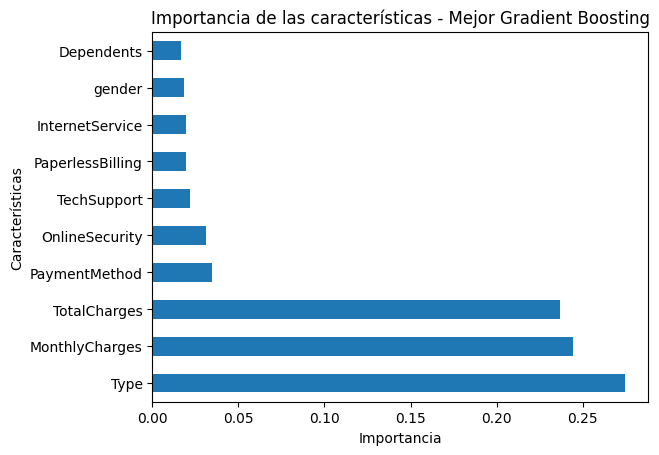

In [40]:
# Importancia de las características del mejor modelo
feature_importances = pd.Series(best_gb.feature_importances_, index=X.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.title("Importancia de las características - Mejor Gradient Boosting")
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.show()


In [41]:

xgb_model = XGBClassifier(random_state=42, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.8)
xgb_model.fit(X_train_balanced, y_train_balanced)
y_val_pred_xgb = xgb_model.predict(X_val)

print("\nF1-Score en validación con XGBoost:", f1_score(y_val, y_val_pred_xgb))



F1-Score en validación con XGBoost: 0.5840978593272171


In [42]:


# Ajuste del umbral para el modelo optimizado
y_val_proba_best_gb = best_gb.predict_proba(X_val)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba_best_gb)
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[f1_scores.argmax()]

print("Mejor umbral para maximizar el F1-score:", best_threshold)

# Recalcular con el nuevo umbral
y_val_pred_adjusted = (y_val_proba_best_gb >= best_threshold).astype(int)
print("\nF1-Score ajustado en validación:", f1_score(y_val, y_val_pred_adjusted))


Mejor umbral para maximizar el F1-score: 0.33420209582019084

F1-Score ajustado en validación: 0.6243093922651933


In [43]:


# Probabilidades del modelo optimizado en el conjunto de validación
y_val_proba_best_gb = best_gb.predict_proba(X_val)[:, 1]

# Calcular precisión, recall y F1-score para diferentes umbrales
precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba_best_gb)
f1_scores = 2 * (precision * recall) / (precision + recall)

# Encontrar el umbral que maximiza el F1-score
best_threshold = thresholds[f1_scores.argmax()]
print("Mejor umbral para maximizar el F1-score:", best_threshold)

# Aplicar el mejor umbral al conjunto de validación
y_val_pred_adjusted = (y_val_proba_best_gb >= best_threshold).astype(int)

# Evaluar métricas con el umbral ajustado
print("\nReporte de clasificación con el mejor umbral:")
print(classification_report(y_val, y_val_pred_adjusted))


Mejor umbral para maximizar el F1-score: 0.33420209582019084

Reporte de clasificación con el mejor umbral:
              precision    recall  f1-score   support

           0       0.91      0.72      0.80       776
           1       0.51      0.81      0.62       280

    accuracy                           0.74      1056
   macro avg       0.71      0.76      0.71      1056
weighted avg       0.80      0.74      0.76      1056



In [44]:
# Aplicar el mejor umbral al conjunto de prueba
y_test_proba_best_gb = best_gb.predict_proba(X_test)[:, 1]
y_test_pred_adjusted = (y_test_proba_best_gb >= 0.3342).astype(int)

# Evaluar métricas en el conjunto de prueba
print("Resultados finales en el conjunto de prueba:")
print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_test_pred_adjusted))

print("\nReporte de clasificación con el mejor umbral:")
print(classification_report(y_test, y_test_pred_adjusted))


Resultados finales en el conjunto de prueba:

Matriz de confusión:
[[577 199]
 [ 78 203]]

Reporte de clasificación con el mejor umbral:
              precision    recall  f1-score   support

           0       0.88      0.74      0.81       776
           1       0.50      0.72      0.59       281

    accuracy                           0.74      1057
   macro avg       0.69      0.73      0.70      1057
weighted avg       0.78      0.74      0.75      1057



In [45]:

# Modelos base
base_models = [
    ('Random Forest', RandomForestClassifier(random_state=42, n_estimators=100)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.8)),
    ('Decision Tree', DecisionTreeClassifier(random_state=42))
]

# Modelo meta (nivel superior)
meta_model = LogisticRegression(random_state=42, max_iter=1000)

# Stacking Classifier
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=3)
stacking_clf.fit(X_train_balanced, y_train_balanced)

# Predicciones en validación
y_val_pred_stacking = stacking_clf.predict(X_val)

# Evaluar el modelo
print("Resultados del modelo Stacking en validación:")
print("\nMatriz de confusión:")
print(confusion_matrix(y_val, y_val_pred_stacking))

print("\nReporte de clasificación:")
print(classification_report(y_val, y_val_pred_stacking))

# Calcular el F1-score
f1_val_stacking = f1_score(y_val, y_val_pred_stacking)
print(f"\nF1-Score en validación: {f1_val_stacking:.2f}")


Resultados del modelo Stacking en validación:

Matriz de confusión:
[[631 145]
 [108 172]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.85      0.81      0.83       776
           1       0.54      0.61      0.58       280

    accuracy                           0.76      1056
   macro avg       0.70      0.71      0.70      1056
weighted avg       0.77      0.76      0.76      1056


F1-Score en validación: 0.58


In [46]:


# Modelo SVM
svm_model = SVC(probability=True, random_state=42, kernel='rbf', C=1, gamma='scale')
svm_model.fit(X_train_balanced, y_train_balanced)

# Modelo Gradient Boosting
gb_model = GradientBoostingClassifier(
    random_state=42, 
    learning_rate=0.1, 
    max_depth=7, 
    n_estimators=200, 
    subsample=0.8
)
gb_model.fit(X_train_balanced, y_train_balanced)

# Evaluar SVM en validación
y_val_pred_svm = svm_model.predict(X_val)
y_val_proba_svm = svm_model.predict_proba(X_val)[:, 1]

print("Resultados de SVM en validación:")
print("\nMatriz de confusión:")
print(confusion_matrix(y_val, y_val_pred_svm))
print("\nReporte de clasificación:")
print(classification_report(y_val, y_val_pred_svm))
f1_val_svm = f1_score(y_val, y_val_pred_svm)
print(f"\nF1-Score en validación (SVM): {f1_val_svm:.2f}")

# Evaluar Gradient Boosting en validación
y_val_pred_gb = gb_model.predict(X_val)
y_val_proba_gb = gb_model.predict_proba(X_val)[:, 1]

print("\nResultados de Gradient Boosting en validación:")
print("\nMatriz de confusión:")
print(confusion_matrix(y_val, y_val_pred_gb))
print("\nReporte de clasificación:")
print(classification_report(y_val, y_val_pred_gb))
f1_val_gb = f1_score(y_val, y_val_pred_gb)
print(f"\nF1-Score en validación (Gradient Boosting): {f1_val_gb:.2f}")


Resultados de SVM en validación:

Matriz de confusión:
[[569 207]
 [ 60 220]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.90      0.73      0.81       776
           1       0.52      0.79      0.62       280

    accuracy                           0.75      1056
   macro avg       0.71      0.76      0.72      1056
weighted avg       0.80      0.75      0.76      1056


F1-Score en validación (SVM): 0.62

Resultados de Gradient Boosting en validación:

Matriz de confusión:
[[612 164]
 [ 89 191]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.87      0.79      0.83       776
           1       0.54      0.68      0.60       280

    accuracy                           0.76      1056
   macro avg       0.71      0.74      0.72      1056
weighted avg       0.78      0.76      0.77      1056


F1-Score en validación (Gradient Boosting): 0.60


In [47]:
# Comparar múltiples modelos
models = {
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(probability=True),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    f1 = f1_score(y_val, y_pred)
    accuracy = accuracy_score(y_val, y_pred)
    results.append((name, f1, accuracy))

# Mostrar resultados
for name, f1, acc in results:
    print(f"{name}: F1-Score={f1:.2f}, Accuracy={acc:.2f}")

Logistic Regression: F1-Score=0.57, Accuracy=0.78
SVM: F1-Score=0.55, Accuracy=0.79
Random Forest: F1-Score=0.54, Accuracy=0.77


Resultados de SVM en el conjunto de prueba:

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.88      0.76      0.81       776
           1       0.52      0.72      0.60       281

    accuracy                           0.75      1057
   macro avg       0.70      0.74      0.71      1057
weighted avg       0.78      0.75      0.76      1057



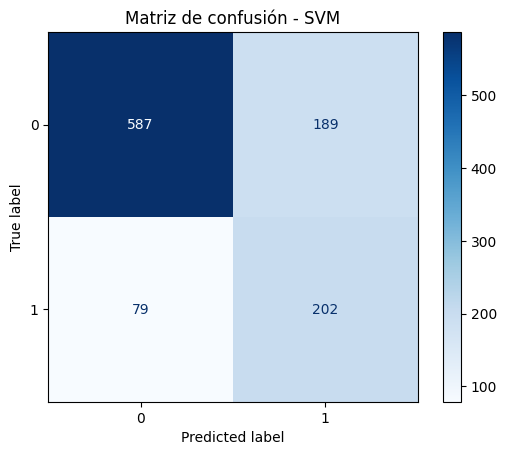

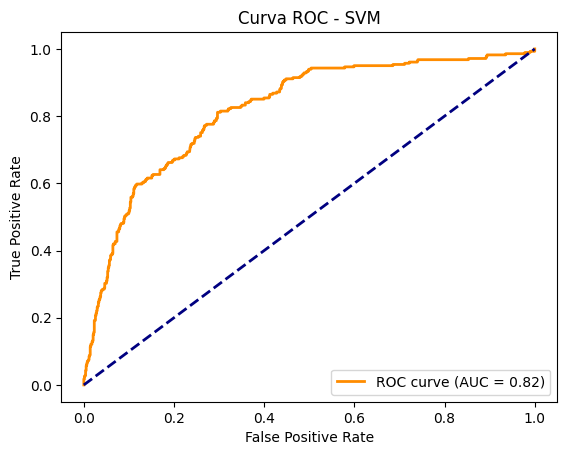

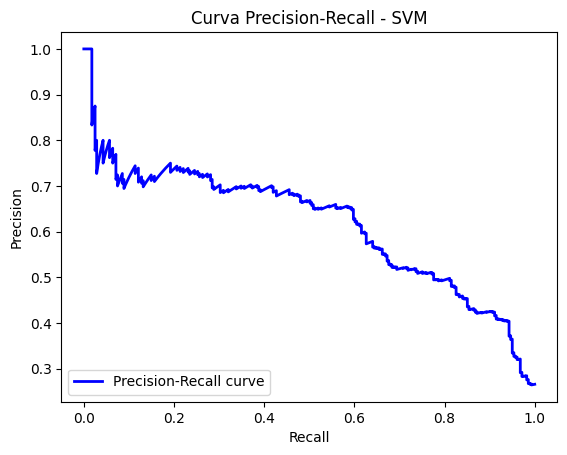

In [48]:

# Evaluar SVM en el conjunto de prueba
y_test_proba_svm = svm_model.predict_proba(X_test)[:, 1]
y_test_pred_svm = svm_model.predict(X_test)

# Reporte y matriz de confusión
print("Resultados de SVM en el conjunto de prueba:")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_test_pred_svm))

# Matriz de confusión
ConfusionMatrixDisplay.from_estimator(svm_model, X_test, y_test, cmap='Blues')
plt.title("Matriz de confusión - SVM")
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_test_proba_svm)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - SVM")
plt.legend(loc="lower right")
plt.show()

# Curva Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_test_proba_svm)
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label="Precision-Recall curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall - SVM")
plt.legend(loc="lower left")
plt.show()


Resultados de Gradient Boosting en el conjunto de prueba:

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.87      0.81      0.84       776
           1       0.55      0.65      0.60       281

    accuracy                           0.77      1057
   macro avg       0.71      0.73      0.72      1057
weighted avg       0.78      0.77      0.77      1057



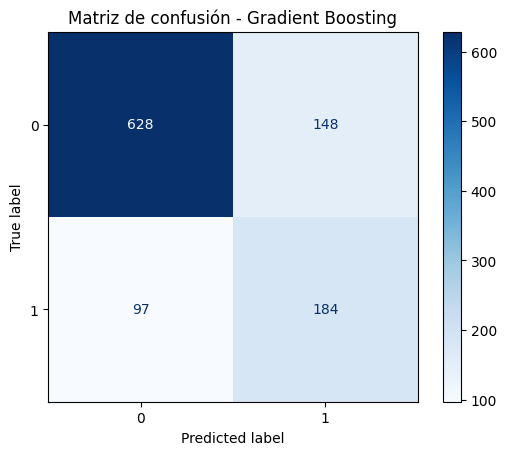

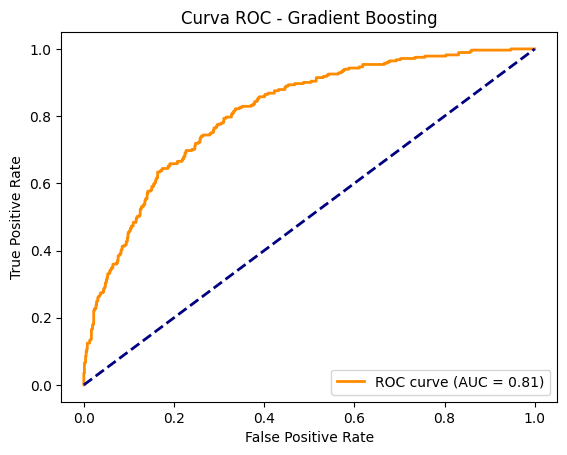

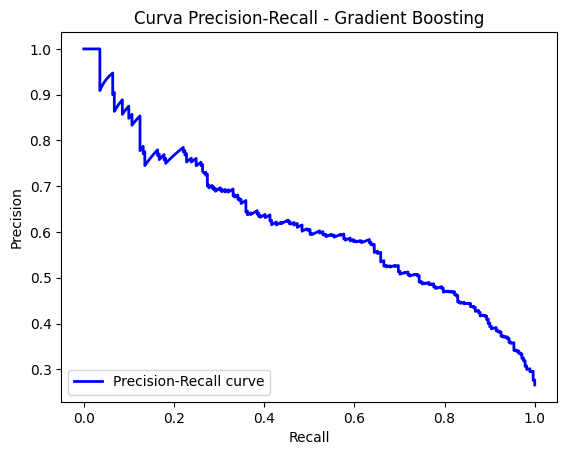

In [49]:
# Evaluar Gradient Boosting en el conjunto de prueba
y_test_proba_gb = gb_model.predict_proba(X_test)[:, 1]
y_test_pred_gb = gb_model.predict(X_test)

# Reporte y matriz de confusión
print("Resultados de Gradient Boosting en el conjunto de prueba:")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_test_pred_gb))

# Matriz de confusión
ConfusionMatrixDisplay.from_estimator(gb_model, X_test, y_test, cmap='Blues')
plt.title("Matriz de confusión - Gradient Boosting")
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_test_proba_gb)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Gradient Boosting")
plt.legend(loc="lower right")
plt.show()

# Curva Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_test_proba_gb)
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label="Precision-Recall curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall - Gradient Boosting")
plt.legend(loc="lower left")
plt.show()


# **Análisis Comparativo: SVM vs Gradient Boosting**

Ambos modelos fueron evaluados con métricas detalladas, matrices de confusión y curvas ROC/Precision-Recall. A continuación, se presentan los resultados y las conclusiones.

---

## **Resultados de SVM**
1. **Reporte de clasificación:**
   - **Clase 0:**
     - Precisión: `0.88`
     - Recall: `0.76`
     - F1-score: `0.81`
   - **Clase 1:**
     - Precisión: `0.52`
     - Recall: `0.72`
     - F1-score: `0.60`
   - **Promedio ponderado F1-score:** `0.76`

2. **Curva ROC:**
   - AUC: `0.82`

3. **Curva Precision-Recall:**
   - Muestra un buen equilibrio, aunque la precisión disminuye rápidamente a medida que aumenta el recall.

4. **Matriz de confusión:**
   - Clase 0:
     - Correctas: `587`
     - Falsos positivos: `189`
   - Clase 1:
     - Correctas: `202`
     - Falsos negativos: `79`

---

## **Resultados de Gradient Boosting**
1. **Reporte de clasificación:**
   - **Clase 0:**
     - Precisión: `0.87`
     - Recall: `0.81`
     - F1-score: `0.84`
   - **Clase 1:**
     - Precisión: `0.55`
     - Recall: `0.65`
     - F1-score: `0.60`
   - **Promedio ponderado F1-score:** `0.77`

2. **Curva ROC:**
   - AUC: `0.81`

3. **Curva Precision-Recall:**
   - Similar a SVM, pero con una caída de precisión un poco más estable.

4. **Matriz de confusión:**
   - Clase 0:
     - Correctas: `628`
     - Falsos positivos: `148`
   - Clase 1:
     - Correctas: `184`
     - Falsos negativos: `97`

---

## **Conclusiones de modelos**

1. **F1-Score:**
   - Ambos modelos tienen un F1-score similar en la clase minoritaria (`1`): **0.60**.
   - **Gradient Boosting** muestra un rendimiento ligeramente mejor en la clase mayoritaria (`0`) con un F1-score de `0.84` frente a `0.81` de SVM.

2. **Recall de la clase minoritaria (`1`):**
   - **SVM** es mejor para capturar la clase `1`, con un recall de `0.72` frente a `0.65` de Gradient Boosting.

3. **Curvas ROC y Precision-Recall:**
   - Ambas curvas son similares, con AUC-ROC de `0.82` (SVM) y `0.81` (Gradient Boosting).
   - Gradient Boosting muestra un mejor equilibrio en la curva Precision-Recall.

4. **Matriz de confusión:**
   - **SVM** tiene más falsos positivos (189 vs. 148 de Gradient Boosting), pero menos falsos negativos (79 vs. 97).
   - Si el objetivo es reducir falsos negativos (mejor recall para la clase `1`), **SVM** es mejor.



# **Conclusiones Generales del Proyecto**

## **Resumen**
Este proyecto se enfocó en analizar los datos de una empresa de telecomunicaciones para predecir la cancelación del servicio ("churn"). Se realizaron múltiples etapas, desde la limpieza y exploración de datos, hasta la implementación y evaluación de modelos de machine learning. A continuación, se presentan las conclusiones clave.

---

## **1. Análisis Exploratorio y Preparación de Datos**
- **Datos iniciales:** Se integraron múltiples fuentes de datos (`contract.csv`, `internet.csv`, `personal.csv`, `phone.csv`) en un único DataFrame.
- **Transformaciones importantes:**
  - Creación de la variable objetivo `churn`, basada en la columna `EndDate`.
  - Conversión de `TotalCharges` de string a numérico y manejo de valores nulos.
  - Escalamiento de variables numéricas (`MonthlyCharges`, `TotalCharges`) y codificación de variables categóricas.
- **Distribución de la variable objetivo:**
  - Se detectó un desbalance inicial en la clase `churn` (73% clase `0`, 27% clase `1`).
  - Se aplicó **SMOTE** para balancear el conjunto de entrenamiento.

---

## **2. Modelos Evaluados**
### **Support Vector Machine (SVM):**
- **Resultados:**
  - F1-score (Clase `1`): `0.60`
  - Recall (Clase `1`): `0.72`
  - AUC-ROC: `0.82`
- **Ventajas:**
  - Alto recall para la clase `1`, capturando más casos de cancelación.
- **Desventajas:**
  - Mayor cantidad de falsos positivos en comparación con Gradient Boosting.

### **Gradient Boosting:**
- **Resultados:**
  - F1-score (Clase `1`): `0.60`
  - Recall (Clase `1`): `0.65`
  - AUC-ROC: `0.81`
- **Ventajas:**
  - Mejor equilibrio entre precisión y recall.
  - Rendimiento más consistente en ambas clases.
- **Desventajas:**
  - Menor recall para la clase minoritaria (`1`), dejando de identificar algunos casos de churn.

---

## **3. Métricas Destacadas**
- **SVM:**
  - Más adecuado para problemas donde es crítico capturar la mayor cantidad posible de casos de cancelación (mejor recall).
- **Gradient Boosting:**
  - Mejor opción para un desempeño balanceado en ambos grupos (`churn` y `no churn`).

---

## **4. Recomendaciones Finales**
1. **Modelo seleccionado:** 
   - Si se prioriza capturar cancelaciones, usar **SVM**.
   - Si el objetivo es un rendimiento balanceado, usar **Gradient Boosting**.
2. **Implementación:**
   - Integrar el modelo en un sistema de predicción en tiempo real para monitorear clientes propensos a cancelar.
3. **Optimización futura:**
   - Probar modelos adicionales como **XGBoost** o técnicas de ensamblado (stacking).
   - Implementar estrategias de reducción de costos computacionales para modelos complejos como SVM.
4. **Mejoras en los datos:**
   - Incluir más características relevantes relacionadas con el comportamiento de los clientes.
   - Realizar análisis adicionales de variables como temporalidad o patrones de uso.

---

## **Conclusión**
El proyecto logró identificar los factores clave para la cancelación del servicio y construir modelos predictivos sólidos. Dependiendo del objetivo del negocio (minimizar falsos negativos o maximizar precisión), se puede implementar un modelo adecuado para mejorar la retención de clientes.
